In [7]:
%pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Librerías importadas correctamente')

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/72.0 MB 10.1 MB/s eta 0:00:07
   -- ------------------------------------- 3.7/72.0 MB 9.1 MB/s eta 0:00:08
   -- ------------------------------------- 5.2/72.0 MB 8.0 MB/s eta 0:00:09
   --- ------------------------------------ 6.8/72.0 MB 7.9 MB/s eta 0:00:09
   ---- ----------------------------------- 8.9/72.0 MB 8.1 MB/s eta 0:00:08
   ------ --------------------------------- 11.3/72.0 MB 8.6 MB/s eta 0:00:08
   -------- ------------------------------- 14.9/72.0 MB 9.7 MB/s eta 0:00:06
   ---------- ----------------------------- 18.6/72.0 MB 10.6 MB/s eta 0:00:06
   ------------ --------------------------- 22.3/72.0 MB 11.3 MB/s eta 0:00:05
   -------------- ------------------------- 25.4/72.0 MB 11.6 MB/s eta 0:00:05
   ---------------- ----------------------- 29.1/72.0 MB 12.1 MB/s eta 0:00:04
   ------------------ --------------------- 32.5/72.0 MB 12.4 MB/s eta 0

### 1.1 Ejemplo de Bootstrapping (media)

Calcularemos muchas medias muestrales para ver su distribución y
estimar intervalos de confianza.

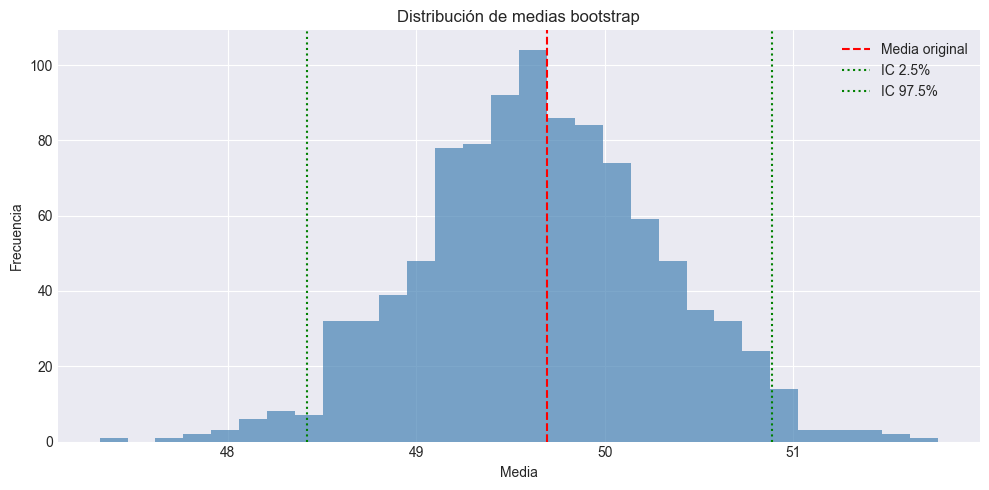

Media original: 49.70
IC 95% bootstrap: [48.42, 50.88]


In [8]:
rng = np.random.default_rng(42)
data = rng.normal(loc=50, scale=10, size=200)

n_boot = 1000
boot_means = []
for _ in range(n_boot):
    sample = rng.choice(data, size=len(data), replace=True)
    boot_means.append(sample.mean())

boot_means = np.array(boot_means)
mean_original = data.mean()
ci_lower, ci_upper = np.percentile(boot_means, [2.5, 97.5])

plt.figure(figsize=(10, 5))
plt.hist(boot_means, bins=30, alpha=0.7, color='steelblue')
plt.axvline(mean_original, color='red', linestyle='--', label='Media original')
plt.axvline(ci_lower, color='green', linestyle=':', label='IC 2.5%')
plt.axvline(ci_upper, color='green', linestyle=':', label='IC 97.5%')
plt.title('Distribución de medias bootstrap')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Media original: {mean_original:.2f}')
print(f'IC 95% bootstrap: [{ci_lower:.2f}, {ci_upper:.2f}]')

---
## 2) Bagging (Bootstrap Aggregating)

**Bagging** entrena múltiples modelos sobre muestras bootstrap
y **promedia/vota** sus predicciones. Reduce varianza y sobreajuste.

### 2.1 Entrenamiento con Iris

Usaremos Bagging con árboles de decisión como modelos base.

Accuracy (Bagging): 0.9666666666666667
OOB Score: 0.9416666666666667
Reporte de clasificación:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



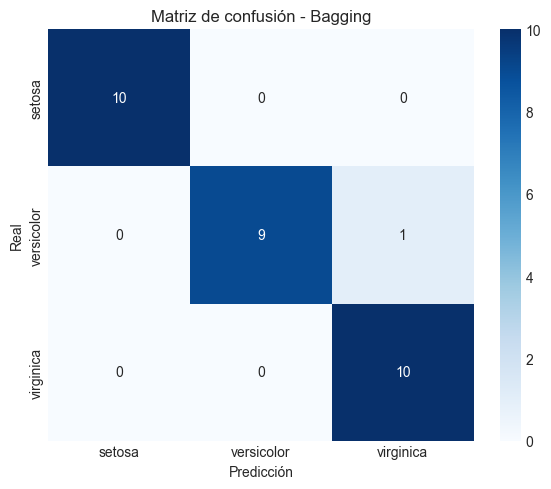

In [9]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='species')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    max_samples=0.8,
    oob_score=True,
    random_state=42
)

bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)

print('Accuracy (Bagging):', accuracy_score(y_test, y_pred_bag))
print('OOB Score:', bagging.oob_score_)
print('Reporte de clasificación:', classification_report(y_test, y_pred_bag, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred_bag)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Bagging')
plt.tight_layout()
plt.show()

---
## 3) Boosting

**Boosting** entrena modelos **secuencialmente**,
dando más peso a los errores anteriores. Reduce sesgo.

### 3.1 AdaBoost

AdaBoost usa modelos débiles (por ejemplo, stumps) y ajusta pesos.

Accuracy (AdaBoost): 0.9333333333333333
Reporte de clasificación:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



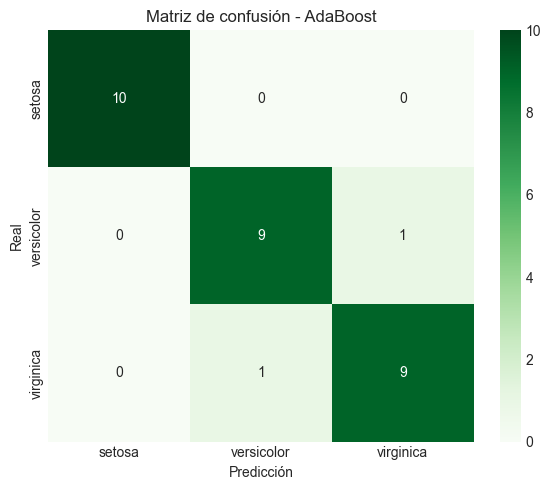

In [10]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print('Accuracy (AdaBoost):', accuracy_score(y_test, y_pred_ada))
print('Reporte de clasificación:', classification_report(y_test, y_pred_ada, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - AdaBoost')
plt.tight_layout()
plt.show()

### 3.2 Gradient Boosting

Gradient Boosting combina modelos débiles corrigiendo errores mediante gradientes.

Accuracy (Gradient Boosting): 0.9666666666666667
Reporte de clasificación:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



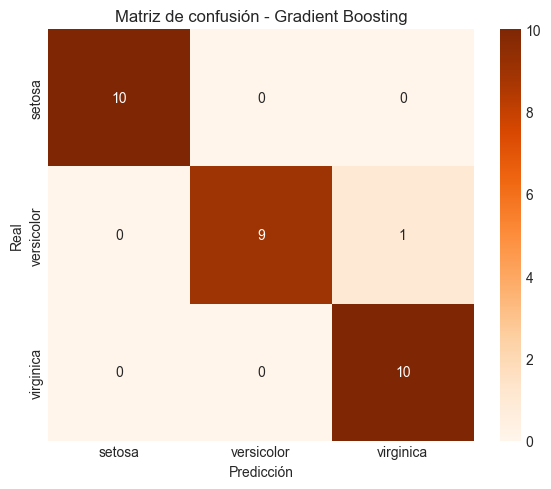

In [11]:
gboost = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gboost.fit(X_train, y_train)
y_pred_gb = gboost.predict(X_test)

print('Accuracy (Gradient Boosting):', accuracy_score(y_test, y_pred_gb))
print('Reporte de clasificación:', classification_report(y_test, y_pred_gb, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Gradient Boosting')
plt.tight_layout()
plt.show()

### 3.3 XGBoost

XGBoost es un boosting más potente y eficiente. Requiere la librería `xgboost`.

Si no la tienes instalada, puedes usar:

```bash
pip install xgboost
```

Accuracy (XGBoost): 0.9
Reporte de clasificación:               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



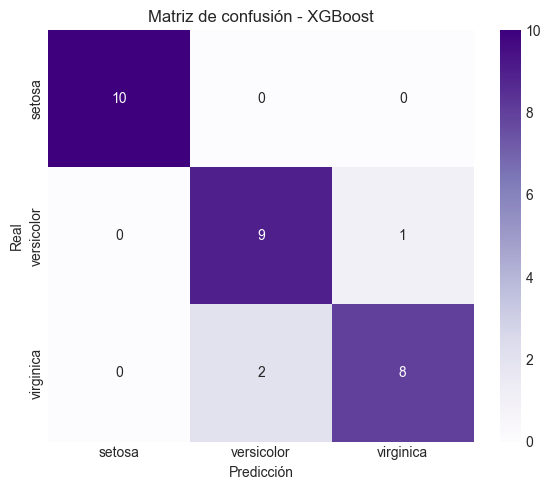

In [12]:
try:
    import xgboost as xgb
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "Falta xgboost. Instala con: pip install xgboost"
    ) from exc

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("Reporte de clasificación:", classification_report(y_test, y_pred_xgb, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - XGBoost')
plt.tight_layout()
plt.show()

---
## 4) Comparación final

Comparamos el rendimiento de Bagging, AdaBoost, Gradient Boosting y XGBoost.

,Modelo,Accuracy
0,Bagging,0.966667
1,AdaBoost,0.933333
2,Gradient Boosting,0.966667
3,XGBoost,0.900000


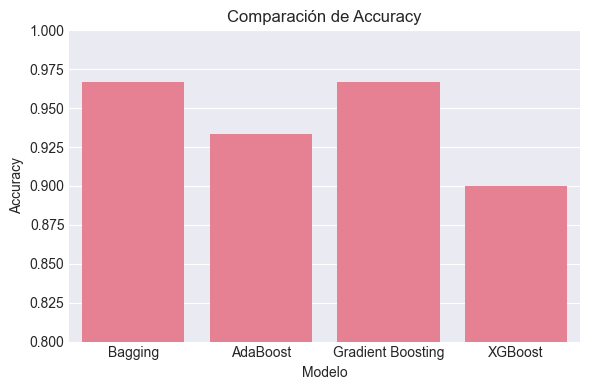

In [13]:
results = pd.DataFrame({
    'Modelo': ['Bagging', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_bag),
        accuracy_score(y_test, y_pred_ada),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_xgb)
    ]
})

display(results)

plt.figure(figsize=(6, 4))
sns.barplot(data=results, x='Modelo', y='Accuracy')
plt.title('Comparación de Accuracy')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

---
## 5) Conclusiones

- **Bootstrapping** estima variabilidad y crea múltiples muestras con reemplazo.
- **Bagging** reduce varianza combinando modelos independientes.
- **Boosting** reduce sesgo y mejora el rendimiento secuencialmente.
- **XGBoost** es un boosting avanzado que suele dar mejores resultados con buen ajuste.

**Regla práctica:**
- Si tu modelo sobreajusta → prueba **Bagging**.
- Si tu modelo es débil → prueba **Boosting**.
- Si quieres el máximo rendimiento → prueba **XGBoost**.